**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Récupération des données et requête SQL](#toc1_1_)    
- [Nettoyage des données](#toc2_)    
  - [Termes spécifiques](#toc2_1_)    
    - [Tags](#toc2_1_1_)    
    - [Langages de programmation issus de Wikipedia](#toc2_1_2_)    
    - [Ensemble des termes métier](#toc2_1_3_)    
    - [Stopwords](#toc2_1_4_)    
    - [Termes à la fois exclus et métier](#toc2_1_5_)    
    - [Ponctuation](#toc2_1_6_)    
  - [Titres](#toc2_2_)    
    - [Nettoyage](#toc2_2_1_)    
    - [Tokenisation](#toc2_2_2_)    
  - [Corps de texte](#toc2_3_)    
  - [Suppression des lignes vides](#toc2_4_)    
  - [Données pré-traitées](#toc2_5_)    
    - [Sauvegarde](#toc2_5_1_)    
    - [Visualisation](#toc2_5_2_)    
- [Vocabulaire](#toc3_)    
    - [🚧 Réécrire :](#toc3_1_1_)    
  - [Titres](#toc3_2_)    
  - [Corps](#toc3_3_)    
  - [Vocabulaire complet : corpus](#toc3_4_)    
- [Statistiques](#toc4_)    
  - [Comptage et fréquence des mots](#toc4_1_)    
    - [🚧 expliquer CountVectorizer](#toc4_1_1_)    
  - [Tableau statistique](#toc4_2_)    
- [🦄🦄 CHECKPOINT 🦄🦄](#toc5_)    
- [🚧 TODO](#toc6_)    
  - [Quelques statistiques](#toc6_1_)    
  - [Répartition des mots](#toc6_2_)    
  - [Répartition des tags](#toc6_3_)    
  - [Répartition des langages de programmation](#toc6_4_)    
  - [🚧 Nuages de mots](#toc6_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
from dotenv import load_dotenv
import os
import logging

# DS
import numpy as np
import pandas as pd
import dill as pickle

# home made functions from the src folder
from src.scrap_and_clean import get_languages
from src.scrap_and_clean import clean_string
from src.scrap_and_clean import tokenize_str
from src.scrap_and_clean import words_filter
from src.eda import make_autopct
from src.eda import create_df
from src.eda import count_occurrences
from src.eda import make_stat_df

# ML
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# dataviz
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# LOGGING configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## <a id='toc1_1_'></a>[Récupération des données et requête SQL](#toc0_)

[Requête disponible sur data.stackexchange.com](https://data.stackexchange.com/stackoverflow/query/1826330/top-50k-relevant-questions), que voici en détails :

``` sql
-- select top 50k questions
SELECT TOP 50000 Title, Body, Tags, Score, AnswerCount, CreationDate, ViewCount
FROM Posts
WHERE PostTypeId = 1 -- (1 for questions)

--filter
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5
AND Score >= 10
AND AnswerCount >= 1

ORDER BY CreationDate DESC
```

La requête est un compromis entre simplicité, qualité maximale et contraintes imposées (questions contenant au moins 5 tags, notamment) :
- pour la qualité, on utilise un **score supérieur supérieur ou égal à 10** avec **au moins 1 réponse** (une seule suffit puisque si elle est de qualité, elle peut suffire à toute la communauté dans bien des cas)
- elle reste **à spectre large** pour tout type de questions
- seules les **données indispensables et conformes au RGPD** sont retournées
- la **variable ViewCount est gardée pour étude** mais pas utilisée comme filtre
    > Elle est relativement corrélée au score, mais pas totalement par :
    > - la **différence d'usage et de comportement** : les vues indexées par les moteurs de recherche amenant de nombreux internautes vs les utilisateurs réguliers de SOF plus exigeants et/ou précis
    > - entre un **sujet très populaire et une niche** qui peuvent avoir tous deux de hauts scores mais un faible viewcount pour la niche
- à l'issue de la requête, on constate que les **dates remontent jusqu'en 2015, ce qui est très actuel** pour la plupart des sujets
    > Cela fait suite à plusieurs tests en amont :  
    > 
    > Sur l'année passée, on obtient 204 réponses à la requête avec le filtre d'au moins 5 tags, 970 sans ce filtre  
    > En changeant le filtre du score avec un score strictement supérieur à 5, on obtient 4426 réponses.
    > 
    > Plusieurs tests ont montré qu'il faut généralement du temps pour qu'une question obtienne un score de 10, selon la popularité du sujet.  
    > Cela n'enlève rien à la qualité potentielle de la question, mais il n'est pas toujours possible de s'en assurer.
    > 
    > Afin de garantir la qualité, le choix est fait d'utiliser le score bien que cela entraîne des données moins récentes.  
    > Les dates remontent jusqu'en 2015, ce qui est tout à fait cohérent au vu des cycles de vie des langages et de production informatique, tout autant que pour la problématique métier qui cherche à aider les nouveaux utilisateurs à partir des usages d'utilisateurs expérimentés.  
- la consigne préconisant un filtre des questions "mises en favori ou jugées pertinentes par les internautes" a été écartée : les **mises en favoris ne semblent plus utilisés** par les internautes et cela entraîne un filtre radical : le score est adopté pour juger de la pertinence

Le résultat de la requête est un fichier CSV de 106Mo.  
Ses données étant ignorées du versionnage, elles seront téléchargées si absentes du dossier :

In [2]:
load_dotenv()
DATA_URL = os.getenv("DATA_URL")
if not os.path.exists("data/data_raw.pkl"):
    print(f"Loading data from {DATA_URL} ...")
    df_raw = pd.read_csv(DATA_URL)
    with open("data/data_raw.pkl", "wb") as f:
        pickle.dump(df_raw, f)
else:
    with open("data/data_raw.pkl", "rb") as f:
        df_raw = pickle.load(f)

Visualisation des données brutes :

In [3]:
df_raw

,Title,Body,Tags,Score,AnswerCount,CreationDate,ViewCount
0,ITMS-91053: Missing API declaration - Privacy,<p>Why am I all of a suddent getting this on s...,<ios><app-store><plist><appstore-approval><pri...,24,7,2024-03-14 22:55:18,3092
1,Why is builtin sorted() slower for a list cont...,<p>I sorted four similar lists. List <code>d</...,<python><algorithm><performance><sorting><time...,28,2,2024-03-05 15:21:50,2699
2,std::shared_mutex::unlock_shared() blocks even...,<p>My team has encountered a deadlock that I s...,<c++><windows><multithreading><stl><shared-lock>,26,5,2024-03-01 23:09:59,1388
3,Did the rules for nullptr init of unique_ptr c...,<p>This code compiles with MSVC from VS 2022 i...,<c++><visual-c++><language-lawyer><unique-ptr>...,15,1,2024-02-22 11:29:42,490
4,Where is the order in which ELF relocations ar...,<p>Consider the following two files on a Linux...,<c++><elf><dynamic-linking><abi><relocation>,16,1,2024-02-19 21:42:03,1746
...,...,...,...,...,...,...,...
49995,Reverse engineer assembly code to c code,<p>I think this is actually a pretty simple pr...,<c><assembly><reverse-engineering><x86-64><con...,10,3,2015-02-12 23:51:30,6771
49996,Combining random forest models in scikit learn,"<p>I have two RandomForestClassifier models, a...",<python><python-2.7><scikit-learn><classificat...,21,2,2015-02-12 23:11:56,13071
49997,How can I get the primary color from my app th...,"<p>In my Android java code, how can I referenc...",<android><android-xml><android-theme><android-...,28,2,2015-02-12 22:58:22,20107
49998,CORS settings for IIS 7.5,<p>How can I convert the following code for us...,<asp.net><iis><cors><web-config><iis-7.5>,12,2,2015-02-12 21:53:34,56289


# <a id='toc2_'></a>[Nettoyage des données](#toc0_)

> **Précision technique UTF-8** :  
> l'encodage par défaut de la méthode read_csv() de Pandas est 'utf-8'  
> de même que le HTMLParser utilisé pour récupérer les langages de programmation ci-après

In [4]:
# keep useful features
df = df_raw.copy()

## <a id='toc2_1_'></a>[Termes spécifiques](#toc0_)

### <a id='toc2_1_1_'></a>[Tags](#toc0_)

Transformation de la colonne en liste de termes :

In [5]:
# change Tags string to list
df["Tags"] = df["Tags"].apply(lambda x: x[1:-1].split("><"))

Recencement de tous les tags utilisés dans les données (sans doublon) :

In [6]:
tags = set()
df["Tags"].apply(lambda x: tags.update(set(x)))
print(len(tags), "existing tags:\n", list(tags)[:10])

16975 existing tags:
 ['normals', 'base64url', 'keymapping', 'puma', 'color-palette', 'non-nullable', 'chakram', 'keycloak-connect', 'random-seed', 'gettext']


### <a id='toc2_1_2_'></a>[Langages de programmation issus de Wikipedia](#toc0_)

Sur StackOverFlow, l'usage ou mention des noms de langages informatiques est très fréquent.  
Non seulement ces langages ont des syntaxes spécifiques (.QL, C++, S, C#...) **facilement éliminées** par des traitements de caractères spéciaux, mais ils sont aussi souvent **représentatifs du sujet** et font fréquemment partie des tags.

In [7]:
prog_lang = get_languages()
print(f"Found {len(prog_lang)} programming languages on Wikipedia")

Found 692 programming languages on Wikipedia


### <a id='toc2_1_3_'></a>[Ensemble des termes métier](#toc0_)

L'union des langages de programmation et des tags recencés :

In [8]:
# concatenate all specific terms
spec_terms = prog_lang | tags
print(f"Total: {len(spec_terms)} specific terms")

Total: 17544 specific terms


À laquelle s'ajoutent quelques noms de langages et framework courts issus à nouveau de [Wikipedia](https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Framework_de_programmation) pour qu'ils ne soient pas éliminés par les traitements ultérieurs : 

In [9]:
add_spec_terms = ["qt", "d3", "hoa", "kde", "s+", "hy"]

spec_terms |= set(add_spec_terms)
print(f"Total: {len(spec_terms)} specific terms")

Total: 17548 specific terms


### <a id='toc2_1_4_'></a>[Stopwords](#toc0_)

Les *stopwords* sont des termes fréquents dans un langage mais dont la présence a un impact très faible sur le sens général du texte.  
Ces mots font partie des termes exclus des textes dans la suite de l'étude.

La bibliothèque NLTK.corpus contient une liste de ces termes en anglais, qu'il est nécessaire de télécharger une première fois :

In [10]:
# nltk.download('stopwords') # only once
stopwords = set(stopwords.words("english"))
print(f"{len(stopwords)} terms\nSample: {list(stopwords)[50:80]}")

179 terms
Sample: ['further', 'above', "won't", "shan't", "should've", 'nor', 'out', "it's", 'other', 'do', "don't", 're', 'myself', 'my', 'before', "shouldn't", 'her', "haven't", 'but', "weren't", 'at', 'd', 'between', 'i', 'was', 'doing', 'itself', 'theirs', 'during', 'its']


Quelques termes additionnels peuvent être ajoutés :

In [11]:
add_stopwords = [
    "can't",
    "d'oh",
    "could't",
    "could'nt",
    "cound't",
    "cound'nt",
    "coulnd't",
    "cdn'ed",
    "doesn'it",
    "does't",
    "don'ts",
    "n't",
    "'nt",
    "i'ca",
    "i'ts",
    "should't",
    "would't",
    "might't",
    "must't",
    "need't",
    "n'th",
    "wont't",
    "non",
]

stopwords |= set(add_stopwords)
print(f"Total: {len(stopwords)} stopwords")

Total: 202 stopwords


### <a id='toc2_1_5_'></a>[Termes à la fois exclus et métier](#toc0_)

Il peut y avoir un conflit avec des termes se trouvant à la fois dans les termes exclus et dans les termes métier ou les tags précédents (e.g. "s", qui est également un langage de programmation).

In [12]:
mutual = stopwords & spec_terms
print(f"{len(mutual)} terms: {mutual}")

9 terms: {'m', 'out', 'any', 'd', 's', 'each', 'between', 'this', 't'}


Après analyse, certains de ces termes existent dans les langages de programmation informatique et peuvent par conséquent :
- être gardés dans les données (donc supprimés de la liste des termes exclus)
- et d'autres écartés (donc supprimés des termes spécifiques)

In [13]:
keep_set = spec_terms.copy()
exclude_set = stopwords.copy()

print(f"Keep: {len(keep_set)} terms")
print(f"Exclude: {len(exclude_set)} terms")

Keep: 17548 terms
Exclude: 202 terms


In [14]:
items_to_keep = ["s", "t", "d"]
keep_set, exclude_set = words_filter(items_to_keep, "add", keep_set, exclude_set)

items_to_remove = [s for s in mutual if s not in items_to_keep]
keep_set, exclude_set = words_filter(items_to_remove, "rm", keep_set, exclude_set)

### <a id='toc2_1_6_'></a>[Ponctuation](#toc0_)

La ponctuation peut aussi être supprimée des termes.  
Certaines entrées ont été ajoutées manuellement suite à de nombreux tests dans les données :

In [15]:
PUNCTUATION = [
    "'",
    '"',
    ",",
    ".",
    ";",
    ":",
    "?",
    "!",
    "+",
    "..",
    "''",
    "``",
    "||",
    "\\\\",
    "\\",
    "==",
    "+=",
    "-=",
    "-",
    "_",
    "=",
    "(",
    ")",
    "[",
    "]",
    "{",
    "}",
    "<",
    ">",
    "/",
    "|",
    "&",
    "*",
    "%",
    "$",
    "#",
    "@",
    "`",
    "^",
    "~",
]

keep_set, exclude_set = words_filter(PUNCTUATION, "rm", keep_set, exclude_set)
print(f"Keep: {len(keep_set)} terms")
print(f"Exclude: {len(exclude_set)} terms")

Keep: 17542 terms
Exclude: 239 terms


## <a id='toc2_2_'></a>[Titres](#toc0_)

### <a id='toc2_2_1_'></a>[Nettoyage](#toc0_)

La fonction `clean_string(str)` fait le nettoyage suivant (dans l'ordre) :
- enlève tout code contenu dans les balises `<code>`** (ni pertinent ni utilisable dans de l'analyse de texte)
- enlève les images contenues dans les balises `<img>`
- enlève du texte tous les tags HTML
- enlève tous les emojis
- enlève les retours à la ligne
- passe le texte en minuscules
- enlève les points de suspension
- enlève les nombres isolés (i.e. séparés par des caractères blancs)
- enlève les espaces multiples

🚧 qd fini -> décommenter

In [16]:
df["Title"] = df["Title"].apply(clean_string)

### <a id='toc2_2_2_'></a>[Tokenisation](#toc0_)

> La *tokenisation* est la division d'une phrase en entités appelées *tokens* (= *jetons*) : des mots, chiffres ou symboles séparés par des caractères blancs.

La fonction `tokenize_str(str, wl, el)` permet une tokenisation nettoyée comme suit (dans l'ordre) :
- tokenisation par la bibliothèque NLTK
- re-soude les négations parfois mal séparées par NLTK (e.g. "n't" de "wasn't")
- prise en charge des dièses ou hashtags "#" lorsqu'ils font partie des langages de programmation
- suppression de la ponctuation en tête et fin de chaîne (exception du point en tête pouvant être un terme métier)
- suppression des tokens de moins de 3 caractères sauf s'ils font partie de la liste des termes métier
- suppression des termes exclus restant (stopwords, ponctuation)

🚧 qd fini -> décommenter

In [17]:
l = ["adsfg", "sdfgb", "gdc", "56hjfg1", "&#$%^", "asfgd3$#$%^"]
l = list(filter(lambda s: any([c.isalnum() for c in s]), l))
l

['adsfg', 'sdfgb', 'gdc', '56hjfg1', 'asfgd3$#$%^']

In [18]:
df["title_tokens"] = df["Title"].apply(
    lambda x: tokenize_str(x, keep_set, exclude_set, PUNCTUATION)
)

## <a id='toc2_3_'></a>[Corps de texte](#toc0_)

Même traitement que pour les titres :

🚧 qd fini -> décommenter

In [19]:
df["Body"] = df["Body"].apply(clean_string)

🚧 qd fini -> décommenter

In [20]:
df["body_tokens"] = df["Body"].apply(
    lambda x: tokenize_str(x, keep_set, exclude_set, PUNCTUATION)
)

## <a id='toc2_4_'></a>[Suppression des lignes vides](#toc0_)

Suppression des entrées avec titre ou corps vide :

🚧 qd fini -> décommenter

In [21]:
df = df.loc[
    (df["title_tokens"].apply(lambda x: len(x) != 0))
    & (df["body_tokens"].apply(lambda x: len(x) != 0)),
]

## <a id='toc2_5_'></a>[Données pré-traitées](#toc0_)

### <a id='toc2_5_1_'></a>[Sauvegarde](#toc0_)

🚧 qd fini -> rétablir commentaire pr sauv sans exec

In [22]:
with open(f"data/df_preprocessed.pkl", "wb") as f:
    pickle.dump(df, f)
# with open("data/df_preprocessed.pkl", "rb") as f:
#     df = pickle.load(f)

### <a id='toc2_5_2_'></a>[Visualisation](#toc0_)

In [23]:
df[["Tags", "title_tokens", "body_tokens"]]

,Tags,title_tokens,body_tokens
0,"[ios, app-store, plist, appstore-approval, pri...","[itms, missing, api, declaration, privacy]","[suddent, getting, successful, builds, apple]"
1,"[python, algorithm, performance, sorting, time...","[builtin, sorted, slower, list, containing, de...","[sorted, four, similar, lists, list, consisten..."
2,"[c++, windows, multithreading, stl, shared-lock]","[std, shared_mutex, unlock_shared, blocks, eve...","[team, encountered, deadlock, suspect, bug, wi..."
3,"[c++, visual-c++, language-lawyer, unique-ptr,...","[rules, nullptr, init, unique_ptr, change, c++]","[code, compiles, msvc, c++, mode, failes, c++,..."
4,"[c++, elf, dynamic-linking, abi, relocation]","[order, elf, relocations, applied, specified]","[consider, following, two, files, linux, syste..."
...,...,...,...
49995,"[c, assembly, reverse-engineering, x86-64, con...","[reverse, engineer, assembly, code, c, code]","[think, actually, pretty, simple, problem, rev..."
49996,"[python, python-2.7, scikit-learn, classificat...","[combining, random, forest, models, scikit, le...","[two, randomforestclassifier, models, would, l..."
49997,"[android, android-xml, android-theme, android-...","[get, primary, color, app, theme]","[android, java, code, reference, color, colorp..."
49998,"[asp.net, iis, cors, web-config, iis-7.5]","[cors, settings, iis]","[convert, following, code, use, web.config, ii..."


# <a id='toc3_'></a>[Vocabulaire](#toc0_)

### <a id='toc3_1_1_'></a>[🚧 Réécrire :](#toc0_)

⚠️ le word_tokenize de NLTK sépare "#" du mot précédent, ce qui est gênant puisqu'utilisé pour plusieurs langages informatiques, très susceptibles d'être utilisés comme tags

une technique consiste à utiliser la bibliothèque Multi-Word Tokenizer, mais elle déforme la sortie : ("C", "#") → "C_#"

le plus cohérent est de vérifier qu'un langage informatique avec cette configuration et de procéder à l'union des mots dans ce seul cas

Création de 3 *bags-of-words* (abrégés *BOW*) séparés, contenant tout le vocabulaire d'un corpus :
- titres
- questions
- corpus (total)

## <a id='toc3_2_'></a>[Titres](#toc0_)

In [24]:
bow_title = set()
df["title_tokens"].apply(lambda x: bow_title.update(set(x)))
print(len(bow_title), "tokens:\n", list(bow_title)[:10])

27467 tokens:
 ['semaphoreslim', 'normals', 'unwantedly', 'incremental', 'gettext', 'envs', 'eta', 'golang', 'o655.count', 'timeofday']


## <a id='toc3_3_'></a>[Corps](#toc0_)

In [25]:
bow_body = set()
df["body_tokens"].apply(lambda x: bow_body.update(set(x)))
print(len(bow_body), "tokens:\n", list(bow_body)[:10])

103746 tokens:
 ['normals', 'semaphoreslim', 'xaf', 'gettext', 'maccro', 'eta', 'grips', 'golang', 'flsliceresult', 'conf']


## <a id='toc3_4_'></a>[Vocabulaire complet : corpus](#toc0_)

In [26]:
# arhur
rain_bow = bow_title | bow_body
print(
    f"Total: {len(rain_bow)} tokens\n({len(bow_title)} from title and {len(bow_body)} from body)"
)

Total: 110214 tokens
(27467 from title and 103746 from body)


# <a id='toc4_'></a>[Statistiques](#toc0_)

## <a id='toc4_1_'></a>[Comptage et fréquence des mots](#toc0_)

### <a id='toc4_1_1_'></a>[🚧 expliquer CountVectorizer](#toc0_)

Création des listes :
- tags existants
- titres des questions
- corps des questions
- corpus = titres + corps

In [27]:
tags_list = df["Tags"].apply(lambda x: " ".join(x)).to_list()
title_list = df["title_tokens"].apply(lambda x: " ".join(x)).to_list()
body_list = df["body_tokens"].apply(lambda x: " ".join(x)).to_list()
corpus_list = title_list + body_list

Comptage des mots et vectorisation **pour le corpus total** :

In [28]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16)
X_cv = count_vectorizer.fit_transform(corpus_list)
count_vectorizer.get_feature_names_out()

array(['.a', '.d.ts', '.extend.withvalue', ..., '�pl+�li���d��', '�s˸8ƍ�',
       '𝐴𝐵−𝐵𝐴'], dtype=object)

Création du tableau statistique du corpus :

In [29]:
stats_df_corpus = pd.DataFrame()
stats_df_corpus["token"] = count_vectorizer.get_feature_names_out()
stats_df_corpus["count_corpus"] = X_cv.sum(axis=0).A1.astype(np.uint16)

# count total and get frequency
tot_corpus = stats_df_corpus.count_corpus.sum()
stats_df_corpus["freq_corpus"] = np.float32(
    stats_df_corpus["count_corpus"] / tot_corpus
)

print(f"DF shape: {stats_df_corpus.shape}")
print(f"Total tokens in corpus: {tot_corpus}")
stats_df_corpus.describe()

DF shape: (110214, 3)
Total tokens in corpus: 3395906


,count_corpus,freq_corpus
count,110214.000000,1.102140e+05
mean,30.811930,9.073257e-06
std,367.961865,1.083546e-04
min,1.000000,2.944722e-07
25%,1.000000,2.944722e-07
50%,1.000000,2.944722e-07
75%,3.000000,8.834167e-07
max,37631.000000,1.108128e-02


Même opération pour les tags, les titres et le corps :

In [30]:
stats_df_tags = make_stat_df(tags_list, "tags")

INFO:root:tags DF shape: (16975, 3)
INFO:root:Total tokens in tags: 249961


In [31]:
stats_df_title = make_stat_df(title_list, "title")

INFO:root:title DF shape: (27467, 3)
INFO:root:Total tokens in title: 308128


In [32]:
stats_df_body = make_stat_df(body_list, "body")

INFO:root:body DF shape: (103746, 3)
INFO:root:Total tokens in body: 3087778


Fusion des 4 tableaux en un seul :

In [33]:
temp_df_cor_tag = pd.merge(stats_df_corpus, stats_df_tags, on="token", how="left")

In [34]:
temp_df_plus_title = pd.merge(temp_df_cor_tag, stats_df_title, on="token", how="left")

In [35]:
stats_df = pd.merge(temp_df_plus_title, stats_df_body, on="token", how="left")

Gestion des valeurs nulles :

In [36]:
stats_df.fillna(0, inplace=True)

Remise en place des types de données originaux :

In [37]:
stats_df = stats_df.astype(
    {"count_tags": "uint16", "count_title": "uint16", "count_body": "uint16"}
)

## <a id='toc4_2_'></a>[Tableau statistique](#toc0_)

Distribution

In [38]:
stats_df.describe()

,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
count,110214.000000,1.102140e+05,110214.000000,110214.000000,110214.000000,110214.000000,110214.000000,1.102140e+05
mean,30.811930,9.073257e-06,1.817446,0.000007,2.795725,0.000009,28.016205,9.073258e-06
std,367.961865,1.083546e-04,48.287415,0.000193,32.152367,0.000104,343.380975,1.112065e-04
min,1.000000,2.944722e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,2.944722e-07,0.000000,0.000000,0.000000,0.000000,1.000000,3.238575e-07
50%,1.000000,2.944722e-07,0.000000,0.000000,0.000000,0.000000,1.000000,3.238575e-07
75%,3.000000,8.834167e-07,0.000000,0.000000,0.000000,0.000000,3.000000,9.715725e-07
max,37631.000000,1.108128e-02,7302.000000,0.029213,4043.000000,0.013121,33588.000000,1.087772e-02


Exploration

In [56]:
stats_df

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
0,.a,28,8.245222e-06,1,0.000004,6,0.000019,22,7.124865e-06
1,.d.ts,18,5.300500e-06,4,0.000016,1,0.000003,17,5.505577e-06
2,.extend.withvalue,1,2.944722e-07,0,0.000000,0,0.000000,1,3.238575e-07
3,.htaccess,55,1.619597e-05,54,0.000216,7,0.000023,48,1.554516e-05
4,.net,3089,9.096247e-04,1277,0.005109,638,0.002071,2451,7.937747e-04
...,...,...,...,...,...,...,...,...,...
110209,，it,1,2.944722e-07,0,0.000000,0,0.000000,1,3.238575e-07
110210,，when,1,2.944722e-07,0,0.000000,0,0.000000,1,3.238575e-07
110211,�pl+�li���d��,1,2.944722e-07,0,0.000000,0,0.000000,1,3.238575e-07
110212,�s˸8ƍ�,1,2.944722e-07,0,0.000000,0,0.000000,1,3.238575e-07


In [39]:
stats_df.loc[50010:50020]

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
50010,jointswp4,1,2.944722e-07,0,0.0,1,0.000003,0,0.000000e+00
50011,joke,4,1.177889e-06,0,0.0,1,0.000003,3,9.715725e-07
50012,jokemodal.tsx,1,2.944722e-07,0,0.0,0,0.000000,1,3.238575e-07
50013,jokers,1,2.944722e-07,0,0.0,0,0.000000,1,3.238575e-07
50014,jolting,1,2.944722e-07,0,0.0,0,0.000000,1,3.238575e-07
50015,joltup,1,2.944722e-07,0,0.0,0,0.000000,1,3.238575e-07
50016,jon,16,4.711555e-06,0,0.0,0,0.000000,16,5.181720e-06
50017,jonas,4,1.177889e-06,0,0.0,0,0.000000,4,1.295430e-06
50018,jonasw,1,2.944722e-07,0,0.0,0,0.000000,1,3.238575e-07
50019,jonathan,8,2.355778e-06,0,0.0,0,0.000000,8,2.590860e-06


Export

In [40]:
with open(f"data/stats_df.pkl", "wb") as f:
    pickle.dump(stats_df, f)

## <a id='toc6_1_'></a>[Quelques statistiques](#toc0_)

Focalisation sur un terme :

In [41]:
stats_df.loc[stats_df.token == "c++"]

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
15268,c++,3645,0.001073,3115,0.012462,716,0.002324,2929,0.000949


Valeurs les plus fréquentes :

In [42]:
stats_df.sort_values(by="count_corpus", ascending=False)

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
103005,using,37631,1.108128e-02,8,0.000032,4043,0.013121,33588,1.087772e-02
18727,code,27900,8.215775e-03,0,0.000000,982,0.003187,26918,8.717596e-03
83694,s,26626,7.840618e-03,0,0.000000,1265,0.004105,25361,8.213350e-03
53641,like,25259,7.438074e-03,0,0.000000,244,0.000792,25015,8.101295e-03
102389,use,24975,7.354444e-03,0,0.000000,2108,0.006841,22867,7.405649e-03
...,...,...,...,...,...,...,...,...,...
59293,mkl_set_num_cores,1,2.944722e-07,0,0.000000,0,0.000000,1,3.238575e-07
59294,mklink,1,2.944722e-07,0,0.000000,0,0.000000,1,3.238575e-07
59295,mklocalsearchcompleter,1,2.944722e-07,0,0.000000,1,0.000003,0,0.000000e+00
17603,circuiting,1,2.944722e-07,0,0.000000,1,0.000003,0,0.000000e+00


In [43]:
stats_df.loc[stats_df.count_corpus > 10]

,token,count_corpus,freq_corpus,count_tags,freq_tags,count_title,freq_title,count_body,freq_body
0,.a,28,0.000008,1,0.000004,6,0.000019,22,0.000007
1,.d.ts,18,0.000005,4,0.000016,1,0.000003,17,0.000006
3,.htaccess,55,0.000016,54,0.000216,7,0.000023,48,0.000016
4,.net,3089,0.000910,1277,0.005109,638,0.002071,2451,0.000794
7,.npmrc,11,0.000003,2,0.000008,2,0.000006,9,0.000003
...,...,...,...,...,...,...,...,...,...
110023,zshrc,23,0.000007,7,0.000028,3,0.000010,20,0.000006
110034,zulu,14,0.000004,0,0.000000,3,0.000010,11,0.000004
110041,zuul,74,0.000022,0,0.000000,16,0.000052,58,0.000019
110055,zxing,14,0.000004,5,0.000020,4,0.000013,10,0.000003


## <a id='toc6_2_'></a>[Répartition des mots](#toc0_)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/

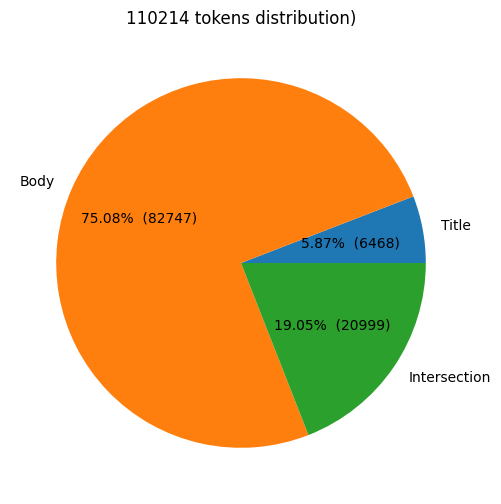

In [44]:
x = [len(bow_title - bow_body), len(bow_body - bow_title), len(bow_title & bow_body)]

plt.figure(figsize=(6, 6))
plt.title(f"{len(rain_bow)} tokens distribution)")
plt.pie(
    x,
    labels=["Title", "Body", "Intersection"],
    autopct=make_autopct(x),
)

plt.show()

## <a id='toc6_3_'></a>[Répartition des tags](#toc0_)

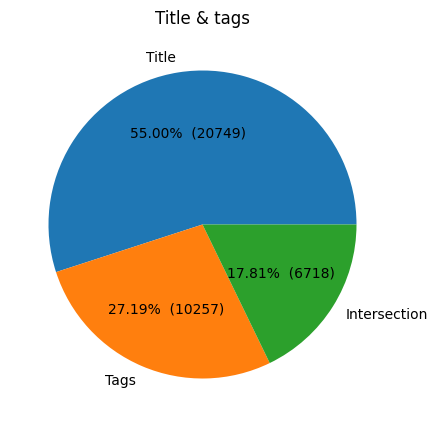

In [45]:
x = [len(bow_title - tags), len(tags - bow_title), len(bow_title & tags)]

plt.figure(figsize=(5, 5))
plt.title(f"Title & tags")
plt.pie(
    x,
    labels=["Title", "Tags", "Intersection"],
    autopct=make_autopct(x),
)

plt.show()

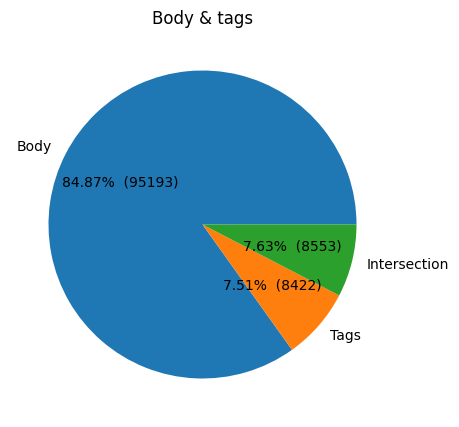

In [46]:
x = [len(bow_body - tags), len(tags - bow_body), len(bow_body & tags)]

plt.figure(figsize=(5, 5))
plt.title(f"Body & tags")
plt.pie(
    x,
    labels=["Body", "Tags", "Intersection"],
    autopct=make_autopct(x),
)

plt.show()

## <a id='toc6_4_'></a>[Répartition des langages de programmation](#toc0_)

🚧 montrer répartition dans les tags pour voir  
🚧 dire q trop peu nombreux pour affichage ?  

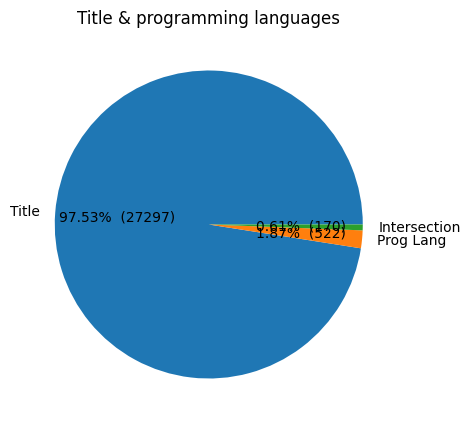

In [47]:
x = [len(bow_title - prog_lang), len(prog_lang - bow_title), len(bow_title & prog_lang)]

plt.figure(figsize=(5, 5))
plt.title(f"Title & programming languages")
plt.pie(
    x,
    labels=["Title", "Prog Lang", "Intersection"],
    autopct=make_autopct(x),
)

plt.show()

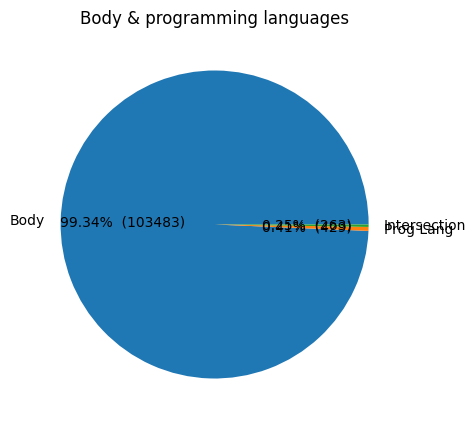

In [48]:
x = [len(bow_body - prog_lang), len(prog_lang - bow_body), len(bow_body & prog_lang)]

plt.figure(figsize=(5, 5))
plt.title(f"Body & programming languages")
plt.pie(
    x,
    labels=["Body", "Prog Lang", "Intersection"],
    autopct=make_autopct(x),
)

plt.show()

## <a id='toc6_5_'></a>[🚧 Nuages de mots](#toc0_)

- ⚠️⚠️ **actuels faux** (basés sur BOW : 1µ/tk)
- nuages pr corpus, tags, title et body

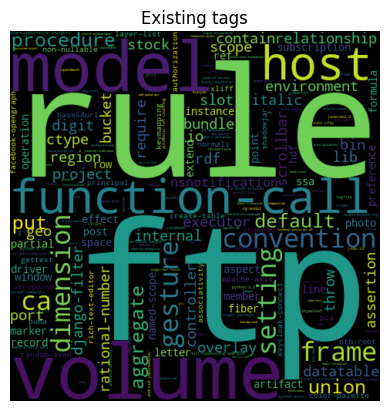

In [49]:
# tags
# Join the different processed titles together.
long_string = " ".join(tags)

# Create the wordcloud object
wordcloud = WordCloud(
    width=480,
    height=480,
    margin=0,
    stopwords=None,
    regexp=r"\S+",
).generate(long_string)

# Display the generated image:
plt.title("Existing tags")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [50]:
wordcloud.words_

{'ftp': 1.0,
 'rule': 1.0,
 'volume': 1.0,
 'model': 1.0,
 'function-call': 1.0,
 'host': 1.0,
 'convention': 1.0,
 'dimension': 1.0,
 'ca': 1.0,
 'gesture': 1.0,
 'frame': 1.0,
 'setting': 1.0,
 'procedure': 1.0,
 'aggregate': 1.0,
 'default': 1.0,
 'put': 1.0,
 'union': 1.0,
 'relationship': 1.0,
 'bucket': 1.0,
 'environment': 1.0,
 'lib': 1.0,
 'project': 1.0,
 'region': 1.0,
 'datatable': 1.0,
 'bundle': 1.0,
 'scope': 1.0,
 'contain': 1.0,
 'django-filter': 1.0,
 'scrollbar': 1.0,
 'executor': 1.0,
 'overlay': 1.0,
 'rational-number': 1.0,
 'controller': 1.0,
 'require': 1.0,
 'geo': 1.0,
 'slot': 1.0,
 'digit': 1.0,
 'ctype': 1.0,
 'rdf': 1.0,
 'bin': 1.0,
 'io': 1.0,
 'internal': 1.0,
 'italic': 1.0,
 'assertion': 1.0,
 'port': 1.0,
 'throw': 1.0,
 'stock': 1.0,
 'nsnotification': 1.0,
 'subscription': 1.0,
 'post': 1.0,
 'effect': 1.0,
 'instance': 1.0,
 'line': 1.0,
 'driver': 1.0,
 'record': 1.0,
 'window': 1.0,
 'member': 1.0,
 'extend': 1.0,
 'marker': 1.0,
 'operation': 1

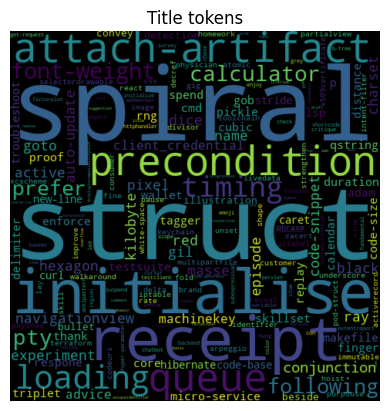

In [51]:
# Join the different processed titles together.
long_string = " ".join(bow_body)

# Create the wordcloud object
wordcloud = WordCloud(
    width=480,
    height=480,
    margin=0,
    stopwords=None,
    regexp=r"\S+",
).generate(long_string)

# Display the generated image:
plt.title("Title tokens")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [52]:
wordcloud.words_

{'spiral': 1.0,
 'struct': 1.0,
 'initialise': 1.0,
 'receipt': 1.0,
 'attach-artifact': 1.0,
 'precondition': 1.0,
 'queue': 1.0,
 'loading': 1.0,
 'timing': 1.0,
 'font-weight': 1.0,
 'calculator': 1.0,
 'pty': 1.0,
 'following': 1.0,
 'prefer': 1.0,
 'conjunction': 1.0,
 'navigationview': 1.0,
 'active': 1.0,
 'dice': 1.0,
 'pixel': 1.0,
 'code-snippet': 1.0,
 'masse': 1.0,
 'hexagon': 1.0,
 'auto-update': 1.0,
 'black': 1.0,
 'charset': 1.0,
 'experiment': 1.0,
 'episode': 1.0,
 'ray': 1.0,
 'red': 1.0,
 'name': 1.0,
 'goto': 1.0,
 'kilobyte': 1.0,
 'gil': 1.0,
 'client_credential': 1.0,
 'machinekey': 1.0,
 'advice': 1.0,
 'micro-service': 1.0,
 'skillset': 1.0,
 'cmd': 1.0,
 'finger': 1.0,
 'lsp': 1.0,
 'cubic': 1.0,
 'triplet': 1.0,
 'p': 1.0,
 'gob': 1.0,
 'distance': 1.0,
 'testsuite': 1.0,
 'adam': 1.0,
 'rng': 1.0,
 'enforce': 1.0,
 'proof': 1.0,
 'qstring': 1.0,
 'troubleshoot': 1.0,
 'duration': 1.0,
 'makefile': 1.0,
 'spend': 1.0,
 'delimiter': 1.0,
 'core': 1.0,
 'respo

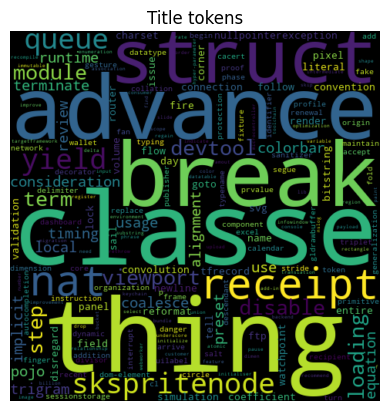

In [53]:
# Join the different processed titles together.
long_string = " ".join(bow_title)

# Create the wordcloud object
wordcloud = WordCloud(
    width=480,
    height=480,
    margin=0,
    stopwords=None,
    regexp=r"\S+",
).generate(long_string)

# Display the generated image:
plt.title("Title tokens")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [54]:
wordcloud.words_

{'classe': 1.0,
 'thing': 1.0,
 'advance': 1.0,
 'break': 1.0,
 'struct': 1.0,
 'receipt': 1.0,
 'nat': 1.0,
 'skspritenode': 1.0,
 'queue': 1.0,
 'yield': 1.0,
 'viewport': 1.0,
 'term': 1.0,
 'loading': 1.0,
 'module': 1.0,
 'disable': 1.0,
 'step': 1.0,
 'devtool': 1.0,
 'consideration': 1.0,
 'pojo': 1.0,
 'alignment': 1.0,
 'coalesce': 1.0,
 'timing': 1.0,
 'colorbar': 1.0,
 'implicit': 1.0,
 'trigram': 1.0,
 'runtime': 1.0,
 'use': 1.0,
 'local': 1.0,
 'usage': 1.0,
 'terminate': 1.0,
 'preset': 1.0,
 'review': 1.0,
 'equation': 1.0,
 'nullpointerexception': 1.0,
 'render': 1.0,
 'ftp': 1.0,
 'connection': 1.0,
 'reformat': 1.0,
 'simulation': 1.0,
 'field': 1.0,
 'pixel': 1.0,
 'flow': 1.0,
 'watchpoint': 1.0,
 'day': 1.0,
 'convolution': 1.0,
 'tell': 1.0,
 'literal': 1.0,
 'bitstring': 1.0,
 'svg': 1.0,
 'follow': 1.0,
 'coefficient': 1.0,
 'newline': 1.0,
 'sail': 1.0,
 'charset': 1.0,
 'volume': 1.0,
 'issue': 1.0,
 'convention': 1.0,
 'entire': 1.0,
 'panel': 1.0,
 'name': 

Nombre de tokens par entrée :

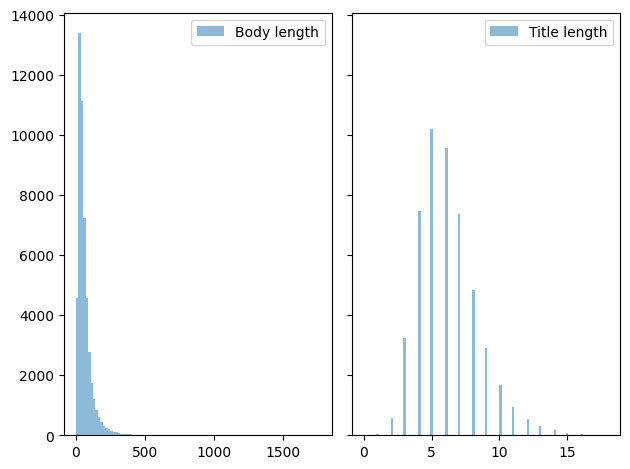

In [55]:
len_titles = []
len_bodies = []

df["title_tokens"].apply(lambda x: len_titles.append(len(x)))
df["body_tokens"].apply(lambda x: len_bodies.append(len(x)))

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(
    len_bodies,
    bins=np.linspace(0, max(len_bodies), 100),
    alpha=0.5,
    label="Body length",
)
axs[1].hist(
    len_titles,
    bins=np.linspace(0, max(len_titles), 100),
    alpha=0.5,
    label="Title length",
)
axs[0].legend(loc="upper right")
axs[1].legend(loc="upper right")

plt.show()